In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Subset
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.func import functional_call
import time
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import random

class Args:
    """Configuration settings"""
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.seed = 42
        self.epochs = 500               # Outer-loop iterations
        self.inner_epochs = 25          # Inner-loop iterations (reduced for stability)
        self.lr_model = 0.01            # Inner-loop learning rate
        self.lr_synth = 0.001           # Learning rate for synthetic data
        self.ipc = 10                   # Images per class
        self.num_classes = 10
        self.batch_size = 128
        self.eval_batch_size = 128
        self.real_batch_size = 128      # Size of real data batch for meta-loss
        self.img_size = 28
        self.channels = 1
        self.model_type = 'simple'      # 'simple' or 'cnn'
        self.save_dir = './distilled_data_improved'
        self.weight_decay = 5e-4        # Weight decay for inner loop
        # Multiple real batches for more stable meta-loss
        self.num_real_batches = 4
        # Use image normalization for better training
        self.mean = 0.1307
        self.std = 0.3081
        # Improved optimizer settings
        self.syn_optim = 'adam'         # 'sgd' or 'adam'
        self.momentum = 0.9             # SGD momentum
        # Initialization method
        self.init_type = 'real'         # 'random', 'real', or 'normal'
        # Temperature for softmax when computing meta-loss
        self.temperature = 1.0
        # Improved sampling strategy
        self.sample_strategy = 'stratified'  # 'random' or 'stratified'

def set_seed(seed):
    """Set random seeds for reproducibility"""
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Network architectures
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        return self.fc4(x)

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.fc1 = nn.Linear(7*7*64, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

def get_network(args):
    """Create and initialize the neural network"""
    if args.model_type == 'simple':
        return SimpleNet().to(args.device)
    elif args.model_type == 'cnn':
        return ConvNet().to(args.device)
    else:
        raise ValueError("Invalid model type")

def get_datasets(args):
    """Load MNIST datasets with appropriate transforms"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((args.mean,), (args.std,))
    ])
    
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # Create stratified subset for each class
    if args.sample_strategy == 'stratified':
        # Create class-balanced training subset
        train_indices = []
        for c in range(args.num_classes):
            idx = (train_dataset.targets == c).nonzero().flatten().tolist()
            train_indices.extend(idx[:5000])  # Limit per class for balanced training
        
        train_subset = Subset(train_dataset, train_indices)
        train_loader = DataLoader(train_subset, batch_size=args.batch_size, shuffle=True)
    else:
        train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
    
    test_loader = DataLoader(test_dataset, batch_size=args.eval_batch_size, shuffle=False)
    
    return train_dataset, train_loader, test_loader

def initialize_synthetic_data(args, train_dataset):
    """Initialize synthetic data with improved strategies"""
    if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)
    
    # Initialize synthetic images with different strategies
    if args.init_type == 'random':
        # Random initialization
        syn_images = torch.randn(
            (args.num_classes * args.ipc, args.channels, args.img_size, args.img_size),
            device=args.device
        )
    elif args.init_type == 'real':
        # Initialize with real images
        indices_class = [[] for _ in range(args.num_classes)]
        for i, label in enumerate(train_dataset.targets):
            indices_class[label].append(i)
        
        syn_images = []
        for c in range(args.num_classes):
            # Randomly select IPC images for class c
            idx_shuffle = np.random.permutation(indices_class[c])[:args.ipc]
            for i in idx_shuffle:
                syn_images.append(train_dataset[i][0])
        
        syn_images = torch.stack(syn_images).to(args.device)
    else:  # 'normal'
        # Gaussian initialization with controlled mean and std
        syn_images = torch.randn(
            (args.num_classes * args.ipc, args.channels, args.img_size, args.img_size),
            device=args.device
        ) * 0.1 + 0.5
    
    # Create balanced labels
    syn_labels = torch.tensor([i for i in range(args.num_classes) for _ in range(args.ipc)], 
                            device=args.device)
    
    # Make synthetic images trainable
    syn_images.requires_grad_(True)
    
    return syn_images, syn_labels

def train_on_synthetic(model, params, images, labels, args):
    """Inner loop: train model on synthetic data with improved training dynamics"""
    for i in range(args.inner_epochs):
        # Forward pass on synthetic data
        outputs = functional_call(model, params, images)
        loss = F.cross_entropy(outputs, labels)
        
        # Add L2 regularization
        l2_reg = 0.0
        for param in params.values():
            l2_reg += torch.norm(param) ** 2
        loss = loss + args.weight_decay * l2_reg
        
        # Compute gradients with respect to current model parameters
        grads = torch.autograd.grad(loss, params.values(), create_graph=True)
        
        # Adjust learning rate with decay schedule
        lr_decay = 1.0  # You can implement cosine decay here if needed
        current_lr = args.lr_model * lr_decay
        
        # Update parameters functionally
        params = {
            name: param - current_lr * g
            for (name, param), g in zip(params.items(), grads)
        }
    
    return params

def evaluate_model(model, data_loader, device):
    """Evaluate model accuracy on the given data loader"""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return 100 * correct / total

def dataset_distillation(args):
    """Main function for dataset distillation with improved techniques"""
    print(f"Using device: {args.device}")
    set_seed(args.seed)
    
    # Load datasets
    train_dataset, train_loader, test_loader = get_datasets(args)
    
    # Initialize synthetic data
    syn_images, syn_labels = initialize_synthetic_data(args, train_dataset)
    
    # Initialize optimizer for synthetic data
    if args.syn_optim == 'sgd':
        optimizer_syn = optim.SGD([syn_images], lr=args.lr_synth, momentum=args.momentum)
        scheduler_syn = StepLR(optimizer_syn, step_size=args.epochs//3, gamma=0.5)
    else:  # adam
        optimizer_syn = optim.Adam([syn_images], lr=args.lr_synth, betas=(0.9, 0.999))
        scheduler_syn = CosineAnnealingLR(optimizer_syn, T_max=args.epochs, eta_min=args.lr_synth/100)
    
    # For recording metrics
    meta_losses = []
    test_accuracies = []
    start_time = time.time()
    
    print(f"Starting meta-training with {args.ipc} images per class...")
    best_meta_loss = float('inf')
    
    # Create multiple real batch iterators
    real_iterators = [iter(train_loader) for _ in range(args.num_real_batches)]
    
    # Training loop
    for epoch in range(args.epochs):
        # Track batch meta-losses
        batch_meta_losses = []
        
        # Iterate through multiple real batches for stable meta-gradient
        for batch_idx in range(args.num_real_batches):
            # Get a batch of real data
            try:
                real_images, real_labels = next(real_iterators[batch_idx])
            except StopIteration:
                real_iterators[batch_idx] = iter(train_loader)
                real_images, real_labels = next(real_iterators[batch_idx])
            
            real_images, real_labels = real_images.to(args.device), real_labels.to(args.device)
            
            # Initialize a fresh model
            model = get_network(args)
            model.train()
            
            # Get initial parameters
            init_params = {name: param.clone() for name, param in model.named_parameters()}
            
            # Inner loop: train on synthetic data
            final_params = train_on_synthetic(model, init_params, syn_images, syn_labels, args)
            
            # Outer loop: compute meta-loss on real data
            outputs_real = functional_call(model, final_params, real_images)
            
            # Compute meta-loss with temperature scaling for soft targets (optional)
            if args.temperature != 1.0:
                outputs_real = outputs_real / args.temperature
            
            meta_loss = F.cross_entropy(outputs_real, real_labels)
            batch_meta_losses.append(meta_loss)
        
        # Average meta-loss over all real batches
        meta_loss = torch.mean(torch.stack(batch_meta_losses))
        
        # Update synthetic data
        optimizer_syn.zero_grad()
        meta_loss.backward()
        
        # Gradient clipping to stabilize training
        torch.nn.utils.clip_grad_norm_([syn_images], 10.0)
        
        optimizer_syn.step()
        scheduler_syn.step()
        
        # Clip synthetic images to valid range (optional but helpful)
        with torch.no_grad():
            syn_images.data = torch.clamp(syn_images.data, -2.0, 2.0)
        
        # Record metrics
        meta_losses.append(meta_loss.item())
        
        # Periodic evaluation and logging
        if (epoch + 1) % 50 == 0 or epoch == 0:
            # Evaluate a model trained on the current synthetic dataset
            eval_model = get_network(args)
            eval_optimizer = optim.SGD(eval_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
            eval_scheduler = CosineAnnealingLR(eval_optimizer, T_max=200, eta_min=0.0001)
            
            # Train on synthetic data
            for e in range(200):  # More epochs for evaluation
                eval_model.train()
                outputs = eval_model(syn_images)
                loss = F.cross_entropy(outputs, syn_labels)
                eval_optimizer.zero_grad()
                loss.backward()
                eval_optimizer.step()
                eval_scheduler.step()
            
            # Test accuracy
            test_acc = evaluate_model(eval_model, test_loader, args.device)
            test_accuracies.append(test_acc)
            
            # Save synthetic data if improved
            if meta_loss.item() < best_meta_loss:
                best_meta_loss = meta_loss.item()
                torch.save({
                    'syn_images': syn_images.detach().cpu(),
                    'syn_labels': syn_labels.detach().cpu(),
                    'meta_loss': best_meta_loss,
                    'test_acc': test_acc
                }, f"{args.save_dir}/best_synth_data.pt")
                # Also save a checkpoint every time we improve
                torch.save({
                    'epoch': epoch,
                    'syn_images': syn_images.detach().cpu(),
                    'syn_labels': syn_labels.detach().cpu(),
                    'optimizer': optimizer_syn.state_dict(),
                    'scheduler': scheduler_syn.state_dict(),
                    'meta_losses': meta_losses,
                    'test_accuracies': test_accuracies
                }, f"{args.save_dir}/checkpoint.pt")
            
            # Always save latest synthetic data
            torch.save({
                'syn_images': syn_images.detach().cpu(),
                'syn_labels': syn_labels.detach().cpu()
            }, f"{args.save_dir}/latest_synth_data.pt")
            
            # Calculate elapsed time and estimated time remaining
            elapsed = time.time() - start_time
            estimated_total = elapsed / (epoch + 1) * args.epochs
            remaining = estimated_total - elapsed
            
            print(f"Epoch [{epoch+1}/{args.epochs}], Meta Loss: {meta_loss.item():.4f}, "
                  f"Test Acc: {test_acc:.2f}%, "
                  f"Time: {elapsed:.1f}s, ETA: {remaining/60:.1f}min")
        
        # Save learning curves periodically
        if (epoch + 1) % 100 == 0:
            plot_learning_curves(meta_losses, test_accuracies, args)
    
    # Final evaluation
    print("\nMeta-training completed. Training final model on distilled dataset...")
    
    # Load best synthetic data
    checkpoint = torch.load(f"{args.save_dir}/best_synth_data.pt")
    best_syn_images = checkpoint['syn_images'].to(args.device)
    best_syn_labels = checkpoint['syn_labels'].to(args.device)
    best_meta_loss = checkpoint['meta_loss']
    
    print(f"Best meta loss achieved: {best_meta_loss:.4f}")
    
    # Train a final model with the distilled dataset
    final_model = get_network(args)
    final_optimizer = optim.SGD(final_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    final_scheduler = CosineAnnealingLR(final_optimizer, T_max=500, eta_min=0.0001)
    
    for epoch in range(500):  # More epochs for final evaluation
        final_model.train()
        outputs = final_model(best_syn_images)
        loss = F.cross_entropy(outputs, best_syn_labels)
        final_optimizer.zero_grad()
        loss.backward()
        final_optimizer.step()
        final_scheduler.step()
        
        if (epoch + 1) % 100 == 0:
            train_acc = evaluate_model(final_model, train_loader, args.device)
            test_acc = evaluate_model(final_model, test_loader, args.device)
            print(f"Final Model - Epoch [{epoch+1}/500], Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")
    
    # Save final model
    torch.save(final_model.state_dict(), f"{args.save_dir}/final_model.pt")
    
    # Visualize distilled images
    save_distilled_images(best_syn_images, best_syn_labels, args)
    
    # Plot final learning curves
    plot_learning_curves(meta_losses, test_accuracies, args)
    
    return best_syn_images, best_syn_labels, final_model

def save_distilled_images(images, labels, args):
    """Save distilled images as a grid"""
    import torchvision.utils as vutils
    
    # Denormalize images
    denorm = transforms.Normalize((-args.mean/args.std,), (1/args.std,))
    images_denorm = torch.stack([denorm(img) for img in images])
    
    # Create a figure with subplots for each class
    plt.figure(figsize=(12, 10))
    
    # Organize images by class
    images_by_class = [[] for _ in range(args.num_classes)]
    for i, label in enumerate(labels):
        images_by_class[label].append(images_denorm[i])
    
    for c in range(args.num_classes):
        if images_by_class[c]:
            class_images = torch.stack(images_by_class[c])
            # Create grid for this class
            grid = vutils.make_grid(class_images, nrow=min(5, len(class_images)), 
                                   padding=2, normalize=True)
            
            # Plot in subplot
            plt.subplot(4, 3, c+1)
            plt.title(f"Class {c}")
            plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)), cmap='gray')
            plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{args.save_dir}/distilled_images_by_class.png", dpi=300)
    plt.close()
    
    # Also create a single grid with all images
    grid = vutils.make_grid(images_denorm, nrow=args.ipc, padding=2, normalize=True)
    plt.figure(figsize=(15, 15))
    plt.title(f"All Distilled MNIST Images ({args.ipc} per class)")
    plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)), cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"{args.save_dir}/distilled_images_all.png", dpi=300)
    plt.close()

def plot_learning_curves(meta_losses, test_accuracies, args):
    """Plot meta-loss and test accuracy curves"""
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(meta_losses)
    plt.title('Meta-Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Meta-Loss')
    plt.grid(True)
    
    # Add a smoothed line
    if len(meta_losses) > 10:
        from scipy.ndimage import gaussian_filter1d
        y_smooth = gaussian_filter1d(meta_losses, sigma=5)
        plt.plot(y_smooth, 'r-')
    
    plt.subplot(1, 2, 2)
    epochs_eval = [i*50 for i in range(len(test_accuracies))]
    plt.plot(epochs_eval, test_accuracies, 'o-')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f"{args.save_dir}/learning_curves.png", dpi=300)
    plt.close()

def run():
    """Main entry point with argument parsing"""
    args = Args()
    
    # Display configuration
    print("Dataset Distillation Configuration:")
    print(f"- Device: {args.device}")
    print(f"- Images per class: {args.ipc}")
    print(f"- Outer epochs: {args.epochs}")
    print(f"- Inner epochs: {args.inner_epochs}")
    print(f"- Model type: {args.model_type}")
    print(f"- Optimizer: {args.syn_optim}")
    print(f"- Initialization: {args.init_type}")
    print(f"- Batch size: {args.batch_size}")
    print(f"- Real batches per meta-update: {args.num_real_batches}")
    print(f"- Save directory: {args.save_dir}")
    
    # Run dataset distillation
    dataset_distillation(args)

if __name__ == "__main__":
    run()

Dataset Distillation Configuration:
- Device: cpu
- Images per class: 10
- Outer epochs: 500
- Inner epochs: 25
- Model type: simple
- Optimizer: adam
- Initialization: real
- Batch size: 128
- Real batches per meta-update: 4
- Save directory: ./distilled_data_improved
Using device: cpu
Starting meta-training with 10 images per class...
Epoch [1/500], Meta Loss: 2.2984, Test Acc: 76.13%, Time: 1.3s, ETA: 11.1min
Epoch [50/500], Meta Loss: 2.3031, Test Acc: 76.33%, Time: 20.5s, ETA: 3.1min
Epoch [100/500], Meta Loss: 2.2952, Test Acc: 75.34%, Time: 44.0s, ETA: 2.9min


KeyboardInterrupt: 

Starting meta-optimization...
Iter   0: Meta-loss: 2.3015, TV: 170267.4531, Total Meta: 19.3282, Avg Inner-loss: 0.0725, Grad Norms: Images 0.0770, Labels 0.0021
Iter  10: Meta-loss: 2.3033, TV: 161288.9219, Total Meta: 18.4322, Avg Inner-loss: 0.0723, Grad Norms: Images 0.0756, Labels 0.0014
Iter  20: Meta-loss: 2.3023, TV: 152641.5938, Total Meta: 17.5665, Avg Inner-loss: 0.0725, Grad Norms: Images 0.0743, Labels 0.0023
Iter  30: Meta-loss: 2.3023, TV: 144314.4062, Total Meta: 16.7337, Avg Inner-loss: 0.0723, Grad Norms: Images 0.0732, Labels 0.0023
Iter  40: Meta-loss: 2.3031, TV: 136307.9375, Total Meta: 15.9339, Avg Inner-loss: 0.0727, Grad Norms: Images 0.0720, Labels 0.0027
Iter  50: Meta-loss: 2.3036, TV: 128620.3750, Total Meta: 15.1656, Avg Inner-loss: 0.0732, Grad Norms: Images 0.0708, Labels 0.0039
Iter  60: Meta-loss: 2.3039, TV: 121242.7188, Total Meta: 14.4282, Avg Inner-loss: 0.0735, Grad Norms: Images 0.0697, Labels 0.0032
Iter  70: Meta-loss: 2.3044, TV: 114167.1797, 

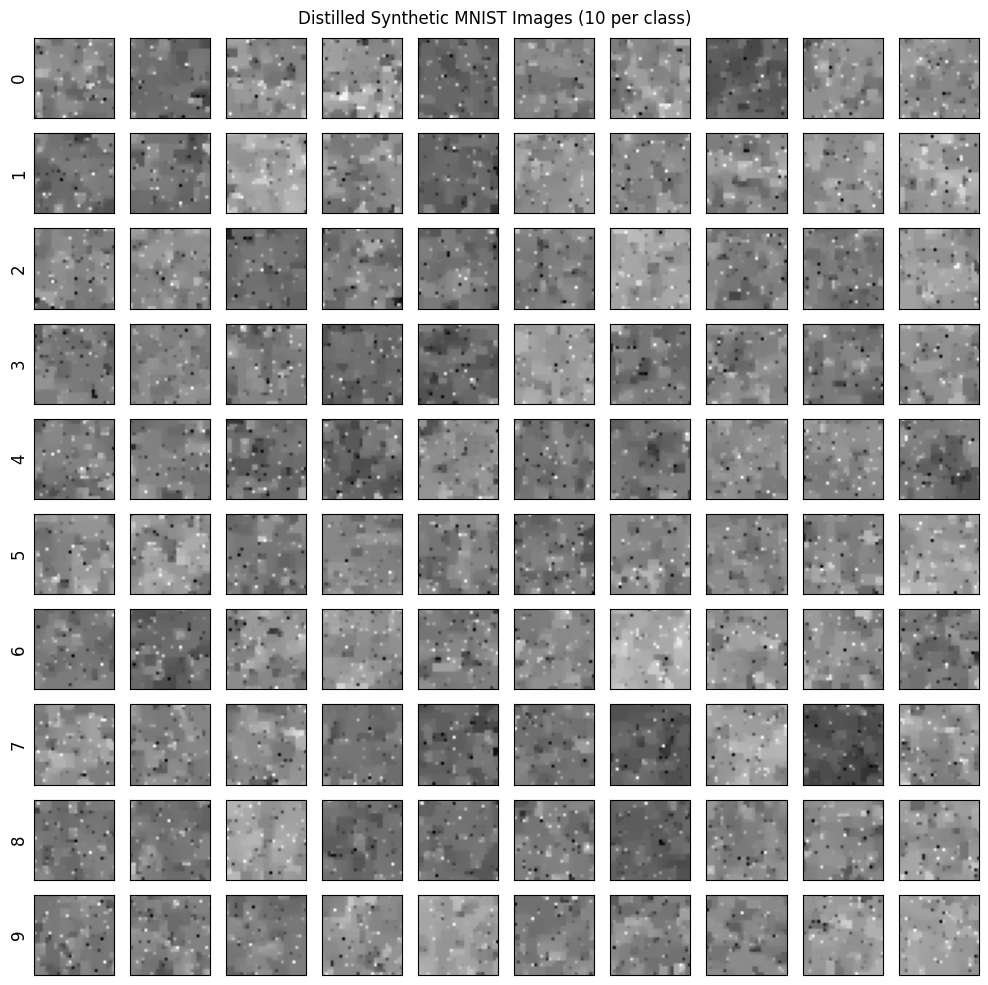

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.func import functional_call
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Set device: GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# Define a simple CNN model
# ---------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)   # 16x28x28
        self.pool = nn.MaxPool2d(2, 2)                              # 16x14x14
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)    # 32x14x14
        self.fc1 = nn.Linear(32 * 14 * 14, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

# ---------------------------
# Load MNIST real dataset
# ---------------------------
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=256, shuffle=True)

# ---------------------------
# Initialize Synthetic Dataset
# ---------------------------
num_syn = 100  # 10 images per each of 10 classes

# Option 1: Initialize synthetic images as random noise (default)
syn_images = torch.randn(num_syn, 1, 28, 28, device=device, requires_grad=True)

# Option 2 (alternative): Initialize from real data (uncomment to use)
# real_data_iter = iter(train_loader)
# real_images, real_labels = next(real_data_iter)
# # Select 10 examples per class (this is a crude selection)
# syn_list = []
# for c in range(10):
#     idx = (real_labels == c).nonzero(as_tuple=True)[0][:10]
#     syn_list.append(real_images[idx])
# syn_images = torch.cat(syn_list, dim=0).clone().detach().to(device)
# syn_images.requires_grad_()

# Initialize synthetic labels: first create without grad, then enable gradients.
syn_labels = torch.zeros(num_syn, 10, device=device)
for i in range(10):
    syn_labels[i*10:(i+1)*10, i] = 1.0
syn_labels.requires_grad_()

# ---------------------------
# Outer optimizer for synthetic data parameters using Adam
# ---------------------------
outer_optimizer = optim.Adam([syn_images, syn_labels], lr=0.005)

# ---------------------------
# Total Variation Loss (Regularizer)
# ---------------------------
def total_variation_loss(x):
    tv_h = torch.sum(torch.abs(x[:, :, :-1, :] - x[:, :, 1:, :]))
    tv_w = torch.sum(torch.abs(x[:, :, :, :-1] - x[:, :, :, 1:]))
    return tv_h + tv_w

tv_weight = 1e-4  # Weight for total variation regularization

# ---------------------------
# Hyperparameters
# ---------------------------
K = 300   # number of outer iterations
T = 25     # number of inner-loop updates
eta = 0.01  # inner-loop learning rate

# ---------------------------
# Training (Meta-Optimization)
# ---------------------------
print("Starting meta-optimization...")
for outer_iter in range(K):
    # Instantiate the network and get its initial parameters as a dictionary.
    net = SimpleCNN(num_classes=10).to(device)
    theta = {name: param.detach().clone().requires_grad_() for name, param in net.named_parameters()}

    inner_loss_sum = 0.0  # To monitor inner-loop loss
    # --------
    # Inner-loop: update network parameters by training on the synthetic data
    # --------
    for t in range(T):
        # Forward pass using functional_call with current theta
        outputs_syn = functional_call(net, theta, syn_images)
        # Compute the inner loss: KL divergence between log-softmax of outputs and softmax of synthetic labels
        loss_syn = F.kl_div(F.log_softmax(outputs_syn, dim=1), 
                            F.softmax(syn_labels, dim=1), 
                            reduction='batchmean')
        inner_loss_sum += loss_syn.item()

        # Compute gradients w.r.t. theta with create_graph=True
        grads = torch.autograd.grad(loss_syn, theta.values(), create_graph=True)
        # Update theta: differentiable gradient descent step
        theta = {name: theta[name] - eta * grad for name, grad in zip(theta.keys(), grads)}

    avg_inner_loss = inner_loss_sum / T

    # --------
    # Outer-loop (Meta-loss): Sample a batch from the real MNIST data and compute the loss.
    # --------
    try:
        real_images, real_labels = next(real_iter)
    except:
        real_iter = iter(train_loader)
        real_images, real_labels = next(real_iter)
    real_images, real_labels = real_images.to(device), real_labels.to(device)
    outputs_real = functional_call(net, theta, real_images)
    meta_loss = F.cross_entropy(outputs_real, real_labels)
    
    # Add TV regularization on synthetic images
    tv_loss = total_variation_loss(syn_images)
    meta_loss_total = meta_loss + tv_weight * tv_loss

    # --------
    # Backpropagation: update synthetic images and labels using the meta-loss
    # --------
    outer_optimizer.zero_grad()
    meta_loss_total.backward()
    outer_optimizer.step()

    # Monitor gradient norms for synthetic images and labels
    syn_images_grad_norm = syn_images.grad.norm().item() if syn_images.grad is not None else 0.0
    syn_labels_grad_norm = syn_labels.grad.norm().item() if syn_labels.grad is not None else 0.0

    if outer_iter % 10 == 0:
        print(f"Iter {outer_iter:3d}: Meta-loss: {meta_loss.item():.4f}, TV: {tv_loss.item():.4f}, "
              f"Total Meta: {meta_loss_total.item():.4f}, Avg Inner-loss: {avg_inner_loss:.4f}, "
              f"Grad Norms: Images {syn_images_grad_norm:.4f}, Labels {syn_labels_grad_norm:.4f}")

# ---------------------------
# Visualize the distilled synthetic images
# ---------------------------
def imshow(img_tensor, title=""):
    img_np = img_tensor.detach().cpu().numpy().squeeze()
    plt.imshow(img_np, cmap='gray')
    plt.title(title)
    plt.axis('off')

# Create a grid: 10 images per class
syn_images_np = syn_images.detach().cpu().clone()
syn_labels_np = F.softmax(syn_labels, dim=1).detach().cpu().numpy()
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for cls in range(10):
    idx = np.where(syn_labels_np.argmax(axis=1) == cls)[0]
    idx = idx[:10]  # take first 10 if there are more
    for j, i in enumerate(idx):
        axes[cls, j].imshow(syn_images_np[i].squeeze(), cmap='gray')
        axes[cls, j].set_xticks([])
        axes[cls, j].set_yticks([])
        if j == 0:
            axes[cls, j].set_ylabel(str(cls), fontsize=12)
plt.suptitle("Distilled Synthetic MNIST Images (10 per class)")
plt.tight_layout()
plt.show()
